In [ ]:
# installing packages (if they do not exist)
!conda install --yes numpy=1.18.5
!conda install --yes pandas=1.2.0
!conda install --yes scikit-learn=0.23.2
!conda install --yes matplotlib=3.2.2
!conda install --yes seaborn=0.10.1


In [10]:
import numpy as np
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import string
from sklearn.model_selection import KFold
from decimal import *
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Functions For Data Preparation

In [11]:
# The following functions may be used in case we need to do a data transformation into categorical data.

def gas_bining(org_df):
    df = org_df.copy()
    
    df['gas_used'] = pd.cut(df['gas_used'], bins=[i * 100000 for i in range(0, 20)], labels=list(string.ascii_uppercase[:19]))
    
    return df


def transform_balance_delta(org_df):
    df = org_df.copy()


    for i in range(0, df.shape[0]):

        if int(df.at[i, 'victim_balance_delta']) == 0:
            df.at[i, 'victim_balance_delta'] = 'zero'

        elif int(df.at[i, 'victim_balance_delta']) > 0:
            df.at[i, 'victim_balance_delta'] = 'positive'

        elif int(df.at[i, 'victim_balance_delta']) < 0:
            df.at[i, 'victim_balance_delta'] = 'negative'


        if int(df.at[i, 'attacker_balance_delta']) == 0:
            df.at[i, 'attacker_balance_delta'] = 'zero'

        elif int(df.at[i, 'attacker_balance_delta']) > 0:
            df.at[i, 'attacker_balance_delta'] = 'positive'

        elif int(df.at[i, 'attacker_balance_delta']) < 0:
            df.at[i, 'attacker_balance_delta'] = 'negative'

        
    return df


def call_stack_depth_bining(org_df):
    df = org_df.copy()

    df['call_stack_depth'] = pd.cut(df['call_stack_depth'], bins=[i for i in range(0, 20)], labels=list(string.ascii_uppercase[:19]))
    
    return df


def replace_labels_col(org_df):
    df = org_df.copy()
    harmful = list()
    labels = list(df['label'])
    
    for label in labels:
        if label == 'safe':
            harmful.append(False)
        elif label == 'vul':
            harmful.append(True)
    
    return harmful

In [12]:
# Helper functions

def get_ys_from_prediction(prediction_df):
    df = prediction_df.copy()
    ys = list()

    col_list = df.columns
    for index, row in df.iterrows():
        max_prob = row.max()
        for col in col_list:
            if row[col] == max_prob:
                predicted = col
                break
        ys.append(predicted)
    
    return ys



def get_fn_fp(y_pred, test_labels):
    fp, fn, tp, tn = 0, 0, 0, 0
    y_pred_list = list(y_pred)
    for i in range(0, len(y_pred_list)):

        if y_pred_list[i] != test_labels[i]:
            if (y_pred_list[i] == "vul" and test_labels[i] == "safe"):
                fp += 1
            if (y_pred_list[i] == 'safe' and test_labels[i] == 'vul'):
                fn += 1
        else:
            
            if (y_pred_list[i] == 'vul' and test_labels[i] == 'vul'):
                tp += 1
            if (y_pred_list[i] == 'safe' and test_labels[i] == 'safe'):
                tn += 1
                
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)

    return (fnr, fpr)

## Defining a constant list of random seeds for numpy

In [13]:
random_seeds = [31403, 31429, 31579, 31523, 31679, 31693, 31589, 31697, 32099, 31871, 31683, 32063, 31403, 32365, 32313, 32363, 32811, 31794, 32195, 31612, 32083, 32579, 32679, 32990, 33347, 32128, 32703, 32132, 31459, 32911, 32003, 33821, 33803, 33086, 34633, 33363, 32735, 31884, 33797, 33548, 34683, 34314, 31907, 31747, 34703, 35318, 31863, 31638, 33707, 33559, 35103, 35891, 35615, 35590, 36101, 33713, 35547, 35393, 31693, 33409, 33743, 32074, 32767, 35183, 35499, 37773, 34175, 38036, 35211, 32783, 35183, 33533, 36659, 37170, 33623, 35153, 37939, 34329, 34835, 32588, 34683, 35453, 32469, 38624, 35771, 36928, 32693, 34883, 34747, 37633, 34913, 36681, 32507, 33542, 37137, 34823, 34187, 34895, 41007, 40016]

## Defining our Classifiers

In [14]:
# Our implementation of a Random Forest with Bagging based on sikitlearn


class RandomForest:

    def __init__(self):
        self.column_filter = None
        self.imputation = None 
        self.one_hot = None 
        self.labels = None 
        self.model = None
        

        # HELPER
        self.no_trees = None

        # DEBUG
        self.tree_predictions_list = None

    
    def fit(self, df, no_trees=100):
        self.no_trees = no_trees
        df = df.copy()

        # initializing our random forest as a list of all our generated trees:
        self.model = list()
        
        y = df['label'].values
        df.drop(columns=['label'], inplace=True)

        
        #df, self.one_hot = create_one_hot(df)
        #df, self.column_filter = create_column_filter(df)
        #df, self.imputation = create_imputation(df)
        
        x = df.values

        # total number of features:
        F_size = len(df.columns)


        # just to use later!
        df_with_classes = df.copy()
        df_with_classes['label'] = pd.Series(y, index=df_with_classes.index)

        def select_with_replacement(trees_i):
            '''
            This function will return a newly selected with replacement sample.
            '''
            np.random.seed(random_seeds[trees_i])
            sample = pd.DataFrame(columns = df_with_classes.columns)
            
            np.random.seed(random_seeds[trees_i])
            selections = np.random.choice(df_with_classes.shape[0], df_with_classes.shape[0], replace=True)
            
            for selection in selections:
                sample = sample.append(df_with_classes.iloc[selection])
                

            return sample 



        for trees_i in range(0, no_trees):
            
            sample_df = select_with_replacement(trees_i)
            
            y = sample_df['label'].values
            sample_df.drop(columns=['label'], inplace=True)
            x = sample_df.values

            self.model.append(DecisionTreeClassifier(max_features='log2'))
            self.model[-1].fit(x, y)

            print('tree # {} is built,'.format(trees_i))


            # I used these lines to get insight into how are my decision trees doing (commented)
            '''
            tree_desc = tree.export_graphviz(self.model[-1], out_file='1_forest/{}.dot'.format(trees_i), feature_names=list(sample_df.columns))
            dot_data = tree.export_graphviz(self.model[-1], feature_names=list(sample_df.columns), class_names=[str(c) for c in self.model[-1].classes_], filled=True, rounded=True)
            graph = graphviz.Source(dot_data)
            graph.render('1_forest/{}.gv'.format(trees_i), view=False)  
            '''
        
        
        
    
        


    
    def predict(self, df):
        test_df = df.copy()

        
        

        #test_df = apply_one_hot(test_df, self.one_hot)
        #test_df = apply_column_filter(test_df, self.column_filter)
        #test_df = apply_imputation(test_df, self.imputation)

        test_x = test_df.values

        # let's add all predictions from all trees to a single list so that we can use it later!
        # each index in this list denotes the prediction of a tree
        tree_predictions_list = list()

        for dt in self.model:
            tree_predictions = dt.predict_proba(test_x)
            tree_predictions_list.append(tree_predictions)

        self.tree_predictions_list = tree_predictions_list



        predictions = pd.DataFrame(columns=['safe' ,'vul'])

        # averaging for each instance:
        for instance_index in range(0, len(test_x)):
            
            total_negative = 0
            total_positive = 0
            
            for model_index in range(0, self.no_trees):
                total_negative += tree_predictions_list[model_index][instance_index][0]
                total_positive += tree_predictions_list[model_index][instance_index][1]
            
            

            predictions = predictions.append({
                'safe': Decimal(total_negative) / Decimal(self.no_trees),
                'vul': Decimal(total_positive) / Decimal(self.no_trees)
            }, ignore_index=True)

        return predictions






def accuracy(original_df, correctlabels):
    
    df = original_df.copy()
    
    '''
    Assumption: I assume that the accuracy is ratio `number of data instances 
    correctly classified / total no of data instances`
    Furthermore, for an instance that does not have a label with highest probability,
    I will choose the first label in column orders as the predicted label for that instance.
    '''
    
    cor_pred = list() # correct predictions list
    inc_pred = list() # incorrect predictions list
    col_list = df.columns
    for index, row in df.iterrows():
        max_prob = row.max()
        for col in col_list:
            if row[col] == max_prob:
                predicted = col
                break
        correct = correctlabels[index]
        if correct == predicted:
            cor_pred.append(index)
        else:
            inc_pred.append(index)
    
    return len(cor_pred)/ len(correctlabels)


    

## Loading the data

In [15]:

df = pd.read_csv('data/transactions2.csv')

# The following dictionary will be used to hold the performance measurements of our classifiers
perfs_dict = {
    'nb': {
    },
    'lr': {
    }, 
    'knn': {
    }, 
    'svm': {
    },
    'rf': {
    }, 
    'nn': {
        
    }
}

display(df)

,Unnamed: 0,tx_hash,gas_used,victim_balance_delta,attacker_balance_delta,call_stack_depth,label
0,0,0x3c2d8496c1dd4b51d49b8f22c8c6546622edc5c2e91b...,66939,0,0,11.191176,safe
1,1,0x9ac733aafba3e2ba4e4a93c2e4d6ff254f09572017a3...,295051,-9500000000000000000,100000000000000000,1.334677,vul
2,2,0x4831d7bf5e7c1f10ad7cab339dcad3fbf013b0e71fc4...,66939,0,0,1.644013,safe
3,3,0x6c359158edd12f83071fe3d3e8639bcdc7b76890b386...,102681,-1900000000000000000,20000000000000000,1.334677,safe
4,4,0x6c359158edd12f83071fe3d3e8639bcdc7b76890b386...,102681,-1900000000000000000,20000000000000000,12.856939,safe
...,...,...,...,...,...,...,...
100,100,0xf9fefdc18938cabddd7ba663cf650308eca0c0f2b624...,199205,-3500000000000000000,3500000000000000000,4.410886,safe
101,101,0xd0d3ffd711a2dfd149c36ae0fde88a83fc77aa695c43...,172953,0,0,5.727010,safe
102,102,0xc6dec90decdfc2f93c4cc67ecd49db8ace335ba99f4b...,170609,-2500000000000000000,2500000000000000000,3.293421,safe
103,103,0xd369b1578f34c9a6fe7f9b80e3226f7f49faef57f0d4...,162546,-6000000000000000000,6000000000000000000,3.734503,vul


## Heatmap correlation matrix

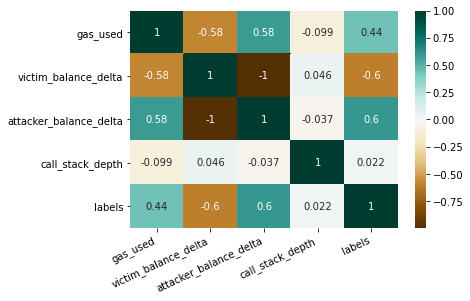

In [24]:
new_df = df.copy()
new_df.drop(columns = ['Unnamed: 0', 'tx_hash'], inplace=True)
new_df['victim_balance_delta'] = pd.to_numeric(new_df['victim_balance_delta'], errors='coerce')
new_df['attacker_balance_delta'] = pd.to_numeric(new_df['attacker_balance_delta'], errors='coerce')

labels = list(new_df['label'])
labels_num = list()
for index in range(0, len(labels)):
    if labels[index] == 'safe':
        labels_num.append(0)
    else:
        labels_num.append(1)

new_df['labels'] = pd.to_numeric(labels_num)

corr_matrix = new_df.corr()
matrix = np.triu(new_df.corr())



plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(corr_matrix, annot = True, cbar_kws= {'orientation': 'vertical'}, cmap='BrBG')
plt.xticks(rotation=25, ha='right')
plt.savefig('new-figures/heatmap.pdf', dpi=300, bbox_inches='tight')

## Applying the classifiers

In [ ]:
# Random Forest 

# trying to scale the data
scaler = StandardScaler()

rf = RandomForest()

kf = KFold(n_splits=5, shuffle=True)

labels = list(df['label'])

accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()

counter = 0 
for train_indices, test_indices in kf.split(df):
    
    
    #pd.DataFrame(train_indices).to_csv("data/processing_steps/train_indices_{}.csv".format(counter))
    #pd.DataFrame(test_indices).to_csv("data/processing_steps/test_indices_{}.csv".format(counter))

    train_indices = pd.read_csv("data/processing_steps/train_indices_{}.csv".format(counter))
    test_indices = pd.read_csv("data/processing_steps/test_indices_{}.csv".format(counter))
    
    train_indices.drop(columns=["Unnamed: 0"], inplace=True)
    test_indices.drop(columns=["Unnamed: 0"], inplace=True) 

    train_indices = train_indices['0'].to_numpy()
    test_indices = test_indices['0'].to_numpy()

    print("TRAIN:", train_indices, "\nTEST:", test_indices)

    counter += 1

    train_df = df.loc[train_indices, :].copy()
    test_df = df.loc[test_indices, :].copy()
    
    train_df.drop(columns=['tx_hash'], inplace=True)
    train_df.drop(columns=['Unnamed: 0'], inplace=True)
    
    test_df.drop(columns=['tx_hash'], inplace=True)
    test_df.drop(columns=['Unnamed: 0'], inplace=True)

    test_labels = list(test_df['label'])
    test_df.drop(columns=['label'], inplace=True)

    train_labels = list(train_df['label'])
    train_df.drop(columns=['label'], inplace=True)

    # scaling:
    scaler.fit(train_df)
    train_ndarray = scaler.transform(train_df)
    test_ndarray = scaler.transform(test_df)

    # let's add the labels to the train_df after scalling, the fit function in our Random Forest classifier needs them:
    train_df = pd.DataFrame(train_ndarray)
    train_df['label'] = train_labels
    test_df = pd.DataFrame(test_ndarray)
    
    rf.fit(train_df, no_trees=100)
    predictions = rf.predict(test_df)

    y_pred = get_ys_from_prediction(predictions)
    print(classification_report(test_labels, y_pred))

    #print(test_labels)
    #print(y_pred)


    # classification report (cr)
    cr = classification_report(test_labels, y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)


    # obtain fp and fn
    fn, fp = get_fn_fp(y_pred, test_labels)
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)

    ac = metrics.accuracy_score(test_labels, y_pred)
    #ac = accuracy(predictions, labels)
    accuracies.append(ac)

    
    print("\nAccuracy of prediction is: {}".format(ac))
    print("========================================================")
    print("========================================================")



print("*********************************************************")
print("\nAverage accuracy: {}".format(sum(accuracies) / len(accuracies)))

perfs_dict['rf']['fp'] = sum(fp_list) / len(fp_list)
perfs_dict['rf']['fn'] = sum(fn_list) / len(fn_list)
perfs_dict['rf']['ac'] = sum(accuracies) / len(accuracies)
perfs_dict['rf']['f1'] = sum(f1_list) / len(f1_list)
perfs_dict['rf']['recall'] = sum(recall_list) / len(recall_list)

print('---------------------------------------------------------')
print(perfs_dict)

In [ ]:
# Logistic Regression

# trying to scale the data
scaler = StandardScaler()

kf = KFold(n_splits=5, shuffle=True)
labels = list(df['label'])

accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()

counter = 0
for train_indices, test_indices in kf.split(df):

    train_indices = pd.read_csv("data/processing_steps/train_indices_{}.csv".format(counter))
    test_indices = pd.read_csv("data/processing_steps/test_indices_{}.csv".format(counter))
    
    train_indices.drop(columns=["Unnamed: 0"], inplace=True)
    test_indices.drop(columns=["Unnamed: 0"], inplace=True) 

    train_indices = train_indices['0'].to_numpy()
    test_indices = test_indices['0'].to_numpy()

    print("TRAIN:", train_indices, "\nTEST:", test_indices)

    counter += 1

    
    train_df = df.loc[train_indices, :].copy()
    test_df = df.loc[test_indices, :].copy()
    
    train_df.drop(columns=['tx_hash'], inplace=True)
    train_df.drop(columns=['Unnamed: 0'], inplace=True)
    
    test_df.drop(columns=['tx_hash'], inplace=True)
    test_df.drop(columns=['Unnamed: 0'], inplace=True)

    train_labels = list(train_df['label'])
    train_df.drop(columns=['label'], inplace=True)

    test_labels = list(test_df['label'])
    test_df.drop(columns=['label'], inplace=True)

    # scaling:
    scaler.fit(train_df)
    train_df = scaler.transform(train_df)
    test_df = scaler.transform(test_df)

    # training
    logreg = LogisticRegression() 
    logreg.fit(train_df, train_labels)

    # prediction
    y_pred=logreg.predict(test_df)

    print(classification_report(test_labels, y_pred))
    

    # classification report (cr)
    cr = classification_report(test_labels, y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)

    # obtain fp and fn
    fn, fp = get_fn_fp(y_pred, test_labels)
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)
    
    print("\nAccuracy of prediction is: {}".format(ac))
    print("========================================================")
    print("========================================================")


print("*********************************************************")
print("\nAverage accuracy: {}".format(sum(accuracies) / len(accuracies)))

perfs_dict['lr']['fp'] = sum(fp_list) / len(fn_list)
perfs_dict['lr']['fn'] = sum(fn_list) / len(fn_list)
perfs_dict['lr']['ac'] = sum(accuracies) / len(accuracies)
perfs_dict['lr']['f1'] = sum(f1_list) / len(f1_list)
perfs_dict['lr']['recall'] = sum(recall_list) / len(recall_list)

print('---------------------------------------------------------')
print(perfs_dict)

In [ ]:
# K-Nearest Neighbors

# trying to scale the data
scaler = StandardScaler()

kf = KFold(n_splits=5, shuffle=True)
labels = list(df['label'])


accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()

counter = 0
for train_indices, test_indices in kf.split(df):
    train_indices = pd.read_csv("data/processing_steps/train_indices_{}.csv".format(counter))
    test_indices = pd.read_csv("data/processing_steps/test_indices_{}.csv".format(counter))
    
    train_indices.drop(columns=["Unnamed: 0"], inplace=True)
    test_indices.drop(columns=["Unnamed: 0"], inplace=True) 

    train_indices = train_indices['0'].to_numpy()
    test_indices = test_indices['0'].to_numpy()

    print("TRAIN:", train_indices, "\nTEST:", test_indices)

    counter += 1

    
    train_df = df.loc[train_indices, :].copy()
    test_df = df.loc[test_indices, :].copy()
    
    train_df.drop(columns=['tx_hash'], inplace=True)
    train_df.drop(columns=['Unnamed: 0'], inplace=True)
    
    test_df.drop(columns=['tx_hash'], inplace=True)
    test_df.drop(columns=['Unnamed: 0'], inplace=True)

    train_labels = list(train_df['label'])
    train_df.drop(columns=['label'], inplace=True)

    test_labels = list(test_df['label'])
    test_df.drop(columns=['label'], inplace=True)

    # scaling:
    scaler.fit(train_df)
    train_df = scaler.transform(train_df)
    test_df = scaler.transform(test_df)

    classifier = KNeighborsClassifier(n_neighbors=5)

    # training
    classifier.fit(train_df, train_labels)

    # prediction
    y_pred = classifier.predict(test_df)
    #print(confusion_matrix(test_labels, y_pred))
    print(classification_report(test_labels, y_pred))  

    # classification report (cr)
    cr = classification_report(test_labels, y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)

    # obtain fp and fn
    fn, fp = get_fn_fp(y_pred, test_labels)
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)  

    # measuring performance
    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)
    
    print("\nAccuracy of prediction is: {}".format(ac))
    print("========================================================")
    print("========================================================")



print("*********************************************************")
print("\nAverage accuracy: {}".format(sum(accuracies) / len(accuracies)))

perfs_dict['knn']['fp'] = sum(fp_list) / len(fp_list)
perfs_dict['knn']['fn'] = sum(fn_list) / len(fp_list)
perfs_dict['knn']['ac'] = sum(accuracies) / len(accuracies)
perfs_dict['knn']['f1'] = sum(f1_list) / len(f1_list)
perfs_dict['knn']['recall'] = sum(recall_list) / len(recall_list)


print('---------------------------------------------------------')
print(perfs_dict)

In [ ]:
# Naive Bayes Classifier

# trying to scale the data
scaler = StandardScaler()

kf = KFold(n_splits=5, shuffle=True)
labels = list(df['label'])


accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()


counter = 0
for train_indices, test_indices in kf.split(df):
    train_indices = pd.read_csv("data/processing_steps/train_indices_{}.csv".format(counter))
    test_indices = pd.read_csv("data/processing_steps/test_indices_{}.csv".format(counter))
    
    train_indices.drop(columns=["Unnamed: 0"], inplace=True)
    test_indices.drop(columns=["Unnamed: 0"], inplace=True) 

    train_indices = train_indices['0'].to_numpy()
    test_indices = test_indices['0'].to_numpy()

    print("TRAIN:", train_indices, "\nTEST:", test_indices)

    counter += 1
    
    train_df = df.loc[train_indices, :].copy()
    test_df = df.loc[test_indices, :].copy()
    
    train_df.drop(columns=['tx_hash'], inplace=True)
    train_df.drop(columns=['Unnamed: 0'], inplace=True)
    
    test_df.drop(columns=['tx_hash'], inplace=True)
    test_df.drop(columns=['Unnamed: 0'], inplace=True)

    train_labels = list(train_df['label'])
    train_df.drop(columns=['label'], inplace=True)

    test_labels = list(test_df['label'])
    test_df.drop(columns=['label'], inplace=True)

    # scaling:
    scaler.fit(train_df)
    #train_df = scaler.transform(train_df)
    #test_df = scaler.transform(test_df)

    # Gaussian Naive Bayes classier:
    gnb = GaussianNB()

    # training
    gnb.fit(train_df, train_labels)

    # prediction
    y_pred = gnb.predict(test_df)
    print(classification_report(test_labels, y_pred))    


    # classification report (cr)
    cr = classification_report(test_labels, y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)


    # obtain fp and fn
    fn, fp = get_fn_fp(y_pred, test_labels)
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)


    # measuring performance
    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)
    
    print("\nAccuracy of prediction is: {}".format(ac))
    print("========================================================")
    print("========================================================")



print("*********************************************************")
print("\nAverage accuracy: {}".format(sum(accuracies) / len(accuracies)))

perfs_dict['nb']['fp'] = sum(fp_list) / len(fp_list)
perfs_dict['nb']['fn'] = sum(fn_list) / len(fn_list)
perfs_dict['nb']['ac'] = sum(accuracies) / len(accuracies)
perfs_dict['nb']['f1'] = sum(f1_list) / len(f1_list)
perfs_dict['nb']['recall'] = sum(recall_list) / len(recall_list)

print('---------------------------------------------------------')
print(perfs_dict)

In [ ]:
# SVM Classifier

# trying to scale the data
scaler = StandardScaler()

kf = KFold(n_splits=5, shuffle=True)
labels = list(df['label'])


accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()


counter = 0 
for train_indices, test_indices in kf.split(df):
    train_indices = pd.read_csv("data/processing_steps/train_indices_{}.csv".format(counter))
    test_indices = pd.read_csv("data/processing_steps/test_indices_{}.csv".format(counter))
    
    train_indices.drop(columns=["Unnamed: 0"], inplace=True)
    test_indices.drop(columns=["Unnamed: 0"], inplace=True) 

    train_indices = train_indices['0'].to_numpy()
    test_indices = test_indices['0'].to_numpy()

    print("TRAIN:", train_indices, "\nTEST:", test_indices)

    counter += 1
    
    train_df = df.loc[train_indices, :].copy()
    test_df = df.loc[test_indices, :].copy()
    
    train_df.drop(columns=['tx_hash'], inplace=True)
    train_df.drop(columns=['Unnamed: 0'], inplace=True)
    
    test_df.drop(columns=['tx_hash'], inplace=True)
    test_df.drop(columns=['Unnamed: 0'], inplace=True)

    train_labels = list(train_df['label'])
    train_df.drop(columns=['label'], inplace=True)

    test_labels = list(test_df['label'])
    test_df.drop(columns=['label'], inplace=True)

    # scaling:
    scaler.fit(train_df)
    train_df = scaler.transform(train_df)
    test_df = scaler.transform(test_df)

    # SVM classier:
    clf = svm.SVC(kernel='linear')

    # training
    clf.fit(train_df, train_labels)

    # prediction
    y_pred = clf.predict(test_df)
    print(classification_report(test_labels, y_pred))    

    # classification report (cr)
    cr = classification_report(test_labels, y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)

    # obtain fp and fn
    fn, fp = get_fn_fp(y_pred, test_labels)
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)

    # measuring performance
    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)
    
    print("\nAccuracy of prediction is: {}".format(ac))
    print("========================================================")
    print("========================================================")



print("*********************************************************")
print("\nAverage accuracy: {}".format(sum(accuracies) / len(accuracies)))

perfs_dict['svm']['fp'] = sum(fp_list) / len(fp_list)
perfs_dict['svm']['fn'] = sum(fn_list) / len(fn_list)
perfs_dict['svm']['ac'] = sum(accuracies) / len(accuracies)
perfs_dict['svm']['f1'] = sum(f1_list) / len(f1_list)
perfs_dict['svm']['recall'] = sum(recall_list) / len(recall_list)

print('---------------------------------------------------------')
print(perfs_dict)

In [ ]:
## Plotting the fpr and fnr


fp_ = list()
fn_ = list()
f1_ = list()
ac_ = list()
recall_ = list()

for classifier, classifier_dict in perfs_dict.items():
    
    fp_.append(round(classifier_dict['fp'] * 100, 2))
    fn_.append(round(classifier_dict['fn'] * 100, 2))
    f1_.append(round(classifier_dict['f1'], 2))
    ac_.append(round(classifier_dict['ac'], 2))
    recall_.append(round(classifier_dict['recall'], 2))


labels = ['NB', 'Logistic Regression', 'K-NN', 'SVM', 'RF']


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars



fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fp_, width, label='FPR', color='mediumseagreen')
rects2 = ax.bar(x + width/2, fn_, width, label='FNR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
#ax.set_title('Number of False Positive and False Negative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.rcParams["figure.figsize"] = (6, 4)
fig.tight_layout()
plt.savefig('new-figures/fpr_fnr.pdf')
plt.show()

In [ ]:
# Ploting the f1_score, accuracy, and recall



labels = ['NB', 'Logistic Regression', 'K-NN', 'SVM', 'RF']


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ac_, width, label='Accuracy', color='mediumseagreen')
rects2 = ax.bar(x + width/2, f1_, width, label='F1 Score')
rects3 = ax.bar(x + 3*width/2, recall_, width, label='Recall')
ax.set_ylim(bottom=0.60)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
#ax.set_title('Number of False Positive and False Negative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects, rect_num=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        
        xytext=(0, 0)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=xytext,  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=35)
        


autolabel(rects1)
autolabel(rects2, rect_num=2)
autolabel(rects3)
fig.tight_layout()

plt.savefig('new-figures/ac_f1_recall.pdf')
plt.show()

In [ ]:
print(perfs_dict)

# Trying the neural network classifiers

In [ ]:
!pip3 install keras

In [ ]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
dataframe = read_csv("sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)


# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=60, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model



# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:

dataframe = pandas.read_csv("sonar.csv", header=None)
dataset = dataframe.values

# split into input (X) and output (Y) variables
#X = dataset[:,0:60].astype(float)
#Y = dataset[:,60]
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)
scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)

X = np.copy(new_df)
Y = np.array(list(df['label']))


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)




# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(4, input_dim=4, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model





# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [104]:

dataframe = pandas.read_csv("sonar.csv", header=None)
dataset = dataframe.values

# split into input (X) and output (Y) variables
#X = dataset[:,0:60].astype(float)
#Y = dataset[:,60]
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)
scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)

#X = new_df.to_numpy()
X = np.copy(new_df)
Y = np.array(list(df['label']))


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)




# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=4, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model





# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



Baseline: 87.45% (8.97%)


In [ ]:
print(results)

## building it like before,

In [106]:


# split into input (X) and output (Y) variables
#X = dataset[:,0:60].astype(float)
#Y = dataset[:,60]
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)
scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)

#X = new_df.to_numpy()
X = np.copy(new_df)
Y = np.array(list(df['label']))


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)




# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=4, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model





# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)









accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()


counter = 0

for i in range(0, 10):
    for train_indices, test_indices in kfold.split(X, Y):
        '''
        train_indices = pd.read_csv("data/processing_steps/train_indices_{}.csv".format(counter))
        test_indices = pd.read_csv("data/processing_steps/test_indices_{}.csv".format(counter))
        
        train_indices.drop(columns=["Unnamed: 0"], inplace=True)
        test_indices.drop(columns=["Unnamed: 0"], inplace=True) 

        train_indices = train_indices['0'].to_numpy()
        test_indices = test_indices['0'].to_numpy()

        print("TRAIN:", train_indices, "\nTEST:", test_indices)

        counter += 1
        
        train_df = df.loc[train_indices, :].copy()
        test_df = df.loc[test_indices, :].copy()
        
        train_df.drop(columns=['tx_hash'], inplace=True)
        train_df.drop(columns=['Unnamed: 0'], inplace=True)
        
        test_df.drop(columns=['tx_hash'], inplace=True)
        test_df.drop(columns=['Unnamed: 0'], inplace=True)

        train_labels = list(train_df['label'])
        train_df.drop(columns=['label'], inplace=True)

        test_labels = list(test_df['label'])
        test_df.drop(columns=['label'], inplace=True)
        '''
        '''
        # scaling:
        scaler.fit(train_df)
        #train_df = scaler.transform(train_df)
        #test_df = scaler.transform(test_df)
        '''

        # training
        estimator.fit(X[train_indices, :], Y[train_indices])

        # prediction
        y_pred = estimator.predict(X[test_indices])
        print(classification_report(Y[test_indices], y_pred))    


        # classification report (cr)
        cr = classification_report(Y[test_indices], y_pred, output_dict=True)
        recall_list.append(cr['vul']['recall'])
        f1_list.append(cr['vul']['f1-score'])

        ac = metrics.accuracy_score(Y[test_indices], y_pred)
        accuracies.append(ac)


        # obtain fp and fn
        fn, fp = get_fn_fp(y_pred, list(Y[test_indices]))
        print('fn is: {0}, fp is: {1}'.format(fn, fp))
        fp_list.append(fp)
        fn_list.append(fn)


        # measuring performance
        ac = metrics.accuracy_score(Y[test_indices], y_pred)
        accuracies.append(ac)
        
        print("\nAccuracy of prediction is: {}".format(ac))
        print("========================================================")
        print("========================================================")
        




print("*********************************************************")
print("\nAverage accuracy: {}".format(sum(accuracies) / len(accuracies)))

perfs_dict['nn']['fp'] = sum(fp_list) / len(fp_list)
perfs_dict['nn']['fn'] = sum(fn_list) / len(fn_list)
perfs_dict['nn']['ac'] = sum(accuracies) / len(accuracies)
perfs_dict['nn']['f1'] = sum(f1_list) / len(f1_list)
perfs_dict['nn']['recall'] = sum(recall_list) / len(recall_list)

print('---------------------------------------------------------')
print(perfs_dict)


              precision    recall  f1-score   support

        safe       0.75      1.00      0.86         6
         vul       1.00      0.60      0.75         5

    accuracy                           0.82        11
   macro avg       0.88      0.80      0.80        11
weighted avg       0.86      0.82      0.81        11

fn is: 0.4, fp is: 0.0

Accuracy of prediction is: 0.8181818181818182
              precision    recall  f1-score   support

        safe       0.71      0.83      0.77         6
         vul       0.75      0.60      0.67         5

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11

fn is: 0.4, fp is: 0.16666666666666666

Accuracy of prediction is: 0.7272727272727273
              precision    recall  f1-score   support

        safe       1.00      1.00      1.00         6
         vul       1.00      1.00      1.00         5

    accuracy              

In [ ]:

dataframe = pandas.read_csv("sonar.csv", header=None)
dataset = dataframe.values

# split into input (X) and output (Y) variables
#X = dataset[:,0:60].astype(float)
#Y = dataset[:,60]
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)
scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)

#X = new_df.to_numpy()
X = np.copy(new_df)
Y = np.array(list(df['label']))


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)




# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=4, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model





# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [127]:
perfs_dict = {'nb': {'fp': 0.05299145299145299, 'fn': 0.24803030303030305, 'ac': 0.8571428571428573, 'f1': 0.8199315596684018, 'recall': 0.751969696969697}, 'lr': {'fp': 0.0, 'fn': 0.2960606060606061, 'ac': 0.8571428571428571, 'f1': 0.8212145748987855, 'recall': 0.703939393939394}, 'knn': {'fp': 0.015384615384615385, 'fn': 0.3710606060606061, 'ac': 0.819047619047619, 'f1': 0.7576248313090418, 'recall': 0.628939393939394}, 'svm': {'fp': 0.046153846153846156, 'fn': 0.2396969696969697, 'ac': 0.8571428571428571, 'f1': 0.8244051304732419, 'recall': 0.7603030303030304}, 'rf': {'fp': 0.01818181818181818, 'fn': 0.07833333333333334, 'ac': 0.9523809523809523, 'f1': 0.9484848484848485, 'recall': 0.9216666666666666}, 'nn': {'fp': 0.042666666666666665, 'fn': 0.22749999999999987, 'ac': 0.8715454545454543, 'f1': 0.8397041847041841, 'recall': 0.7724999999999995}}

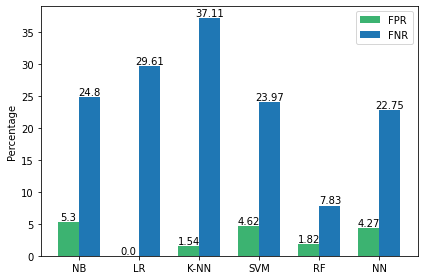

In [128]:

fp_ = list()
fn_ = list()
f1_ = list()
ac_ = list()
recall_ = list()

for classifier, classifier_dict in perfs_dict.items():
    
    fp_.append(round(classifier_dict['fp'] * 100, 2))
    fn_.append(round(classifier_dict['fn'] * 100, 2))
    f1_.append(round(classifier_dict['f1'], 2))
    ac_.append(round(classifier_dict['ac'], 2))
    recall_.append(round(classifier_dict['recall'], 2))


labels = ['NB', 'LR', 'K-NN', 'SVM', 'RF', 'NN']


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars



fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fp_, width, label='FPR', color='mediumseagreen')
rects2 = ax.bar(x + width/2, fn_, width, label='FNR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
#ax.set_title('Number of False Positive and False Negative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.rcParams["figure.figsize"] = (6, 4)
fig.tight_layout()
plt.savefig('new-figures/fpr_fnr.pdf')
plt.show()

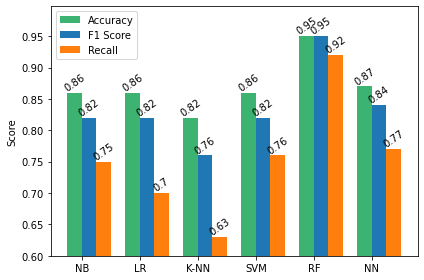

In [129]:
# Ploting the f1_score, accuracy, and recall



labels = ['NB', 'LR', 'K-NN', 'SVM', 'RF', 'NN']


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ac_, width, label='Accuracy', color='mediumseagreen')
rects2 = ax.bar(x + width/2, f1_, width, label='F1 Score')
rects3 = ax.bar(x + 3*width/2, recall_, width, label='Recall')
ax.set_ylim(bottom=0.60)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
#ax.set_title('Number of False Positive and False Negative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects, rect_num=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        
        xytext=(0, 0)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=xytext,  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=35)
        


autolabel(rects1)
autolabel(rects2, rect_num=2)
autolabel(rects3)
fig.tight_layout()

plt.savefig('new-figures/ac_f1_recall.pdf')
plt.show()

# Doing the same thing for the experiment without the callstack depth

In [117]:

dataframe = pandas.read_csv("sonar.csv", header=None)
dataset = dataframe.values

# split into input (X) and output (Y) variables
#X = dataset[:,0:60].astype(float)
#Y = dataset[:,60]
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)
new_df.drop(columns=["call_stack_depth"], inplace=True)
scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)

#X = new_df.to_numpy()
X = np.copy(new_df)
Y = np.array(list(df['label']))


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)




# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=3, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model





# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)









accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()


counter = 0

for i in range(0, 10):
    for train_indices, test_indices in kfold.split(X, Y):
        '''
        train_indices = pd.read_csv("data/processing_steps/train_indices_{}.csv".format(counter))
        test_indices = pd.read_csv("data/processing_steps/test_indices_{}.csv".format(counter))
        
        train_indices.drop(columns=["Unnamed: 0"], inplace=True)
        test_indices.drop(columns=["Unnamed: 0"], inplace=True) 

        train_indices = train_indices['0'].to_numpy()
        test_indices = test_indices['0'].to_numpy()

        print("TRAIN:", train_indices, "\nTEST:", test_indices)

        counter += 1
        
        train_df = df.loc[train_indices, :].copy()
        test_df = df.loc[test_indices, :].copy()
        
        train_df.drop(columns=['tx_hash'], inplace=True)
        train_df.drop(columns=['Unnamed: 0'], inplace=True)
        
        test_df.drop(columns=['tx_hash'], inplace=True)
        test_df.drop(columns=['Unnamed: 0'], inplace=True)

        train_labels = list(train_df['label'])
        train_df.drop(columns=['label'], inplace=True)

        test_labels = list(test_df['label'])
        test_df.drop(columns=['label'], inplace=True)
        '''
        '''
        # scaling:
        scaler.fit(train_df)
        #train_df = scaler.transform(train_df)
        #test_df = scaler.transform(test_df)
        '''

        # training
        estimator.fit(X[train_indices, :], Y[train_indices])

        # prediction
        y_pred = estimator.predict(X[test_indices])
        print(classification_report(Y[test_indices], y_pred))    


        # classification report (cr)
        cr = classification_report(Y[test_indices], y_pred, output_dict=True)
        recall_list.append(cr['vul']['recall'])
        f1_list.append(cr['vul']['f1-score'])

        ac = metrics.accuracy_score(Y[test_indices], y_pred)
        accuracies.append(ac)


        # obtain fp and fn
        fn, fp = get_fn_fp(y_pred, list(Y[test_indices]))
        print('fn is: {0}, fp is: {1}'.format(fn, fp))
        fp_list.append(fp)
        fn_list.append(fn)


        # measuring performance
        ac = metrics.accuracy_score(Y[test_indices], y_pred)
        accuracies.append(ac)
        
        print("\nAccuracy of prediction is: {}".format(ac))
        print("========================================================")
        print("========================================================")
        




print("*********************************************************")
print("\nAverage accuracy: {}".format(sum(accuracies) / len(accuracies)))

perfs_dict['nn']['fp'] = sum(fp_list) / len(fp_list)
perfs_dict['nn']['fn'] = sum(fn_list) / len(fn_list)
perfs_dict['nn']['ac'] = sum(accuracies) / len(accuracies)
perfs_dict['nn']['f1'] = sum(f1_list) / len(f1_list)
perfs_dict['nn']['recall'] = sum(recall_list) / len(recall_list)

print('---------------------------------------------------------')
print(perfs_dict)


              precision    recall  f1-score   support

        safe       0.83      0.83      0.83         6
         vul       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11

fn is: 0.2, fp is: 0.16666666666666666

Accuracy of prediction is: 0.8181818181818182
              precision    recall  f1-score   support

        safe       0.75      0.50      0.60         6
         vul       0.57      0.80      0.67         5

    accuracy                           0.64        11
   macro avg       0.66      0.65      0.63        11
weighted avg       0.67      0.64      0.63        11

fn is: 0.2, fp is: 0.5

Accuracy of prediction is: 0.6363636363636364
              precision    recall  f1-score   support

        safe       0.71      0.83      0.77         6
         vul       0.75      0.60      0.67         5

    accuracy              

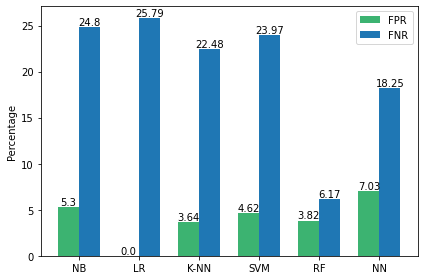

In [125]:

fp_ = list()
fn_ = list()
f1_ = list()
ac_ = list()
recall_ = list()

for classifier, classifier_dict in perfs_dict.items():
    
    fp_.append(round(classifier_dict['fp'] * 100, 2))
    fn_.append(round(classifier_dict['fn'] * 100, 2))
    f1_.append(round(classifier_dict['f1'], 2))
    ac_.append(round(classifier_dict['ac'], 2))
    recall_.append(round(classifier_dict['recall'], 2))


labels = ['NB', 'LR', 'K-NN', 'SVM', 'RF', 'NN']


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars



fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fp_, width, label='FPR', color='mediumseagreen')
rects2 = ax.bar(x + width/2, fn_, width, label='FNR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
#ax.set_title('Number of False Positive and False Negative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.rcParams["figure.figsize"] = (6, 4)
fig.tight_layout()
plt.savefig('new-figures/fpr_fnr_no-callstack-depth.pdf')
plt.show()

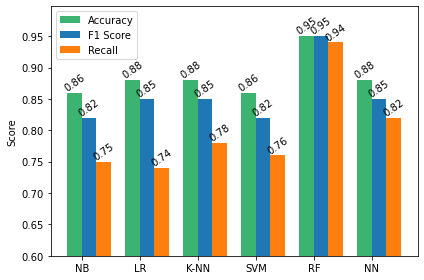

In [126]:
# Ploting the f1_score, accuracy, and recall



labels = ['NB', 'LR', 'K-NN', 'SVM', 'RF', 'NN']


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ac_, width, label='Accuracy', color='mediumseagreen')
rects2 = ax.bar(x + width/2, f1_, width, label='F1 Score')
rects3 = ax.bar(x + 3*width/2, recall_, width, label='Recall')
ax.set_ylim(bottom=0.60)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
#ax.set_title('Number of False Positive and False Negative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects, rect_num=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        
        xytext=(0, 0)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=xytext,  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=35)
        


autolabel(rects1)
autolabel(rects2, rect_num=2)
autolabel(rects3)
fig.tight_layout()

plt.savefig('new-figures/ac_f1_recall-no-callstack-depth.pdf')
plt.show()

In [ ]:

import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



# split into input (X) and output (Y) variables
#X = dataset[:,0:60].astype(float)
#Y = dataset[:,60]
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)
scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)

#X = new_df.to_numpy()
X = np.copy(new_df)
Y = np.array(list(df['label']))


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)




# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=4, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model





# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)









accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()


counter = 0

for i in range(0, 10):
    for train_indices, test_indices in kfold.split(X, Y):
        '''
        train_indices = pd.read_csv("data/processing_steps/train_indices_{}.csv".format(counter))
        test_indices = pd.read_csv("data/processing_steps/test_indices_{}.csv".format(counter))
        
        train_indices.drop(columns=["Unnamed: 0"], inplace=True)
        test_indices.drop(columns=["Unnamed: 0"], inplace=True) 

        train_indices = train_indices['0'].to_numpy()
        test_indices = test_indices['0'].to_numpy()

        print("TRAIN:", train_indices, "\nTEST:", test_indices)

        counter += 1
        
        train_df = df.loc[train_indices, :].copy()
        test_df = df.loc[test_indices, :].copy()
        
        train_df.drop(columns=['tx_hash'], inplace=True)
        train_df.drop(columns=['Unnamed: 0'], inplace=True)
        
        test_df.drop(columns=['tx_hash'], inplace=True)
        test_df.drop(columns=['Unnamed: 0'], inplace=True)

        train_labels = list(train_df['label'])
        train_df.drop(columns=['label'], inplace=True)

        test_labels = list(test_df['label'])
        test_df.drop(columns=['label'], inplace=True)
        '''
        '''
        # scaling:
        scaler.fit(train_df)
        #train_df = scaler.transform(train_df)
        #test_df = scaler.transform(test_df)
        '''

        # training
        estimator.fit(X[train_indices, :], Y[train_indices])

        # prediction
        y_pred = estimator.predict(X[test_indices])
        print(classification_report(Y[test_indices], y_pred))    


        # classification report (cr)
        cr = classification_report(Y[test_indices], y_pred, output_dict=True)
        recall_list.append(cr['vul']['recall'])
        f1_list.append(cr['vul']['f1-score'])

        ac = metrics.accuracy_score(Y[test_indices], y_pred)
        accuracies.append(ac)


        # obtain fp and fn
        fn, fp = get_fn_fp(y_pred, list(Y[test_indices]))
        print('fn is: {0}, fp is: {1}'.format(fn, fp))
        fp_list.append(fp)
        fn_list.append(fn)


        # measuring performance
        ac = metrics.accuracy_score(Y[test_indices], y_pred)
        accuracies.append(ac)
        
        print("\nAccuracy of prediction is: {}".format(ac))
        print("========================================================")
        print("========================================================")
        




print("*********************************************************")
print("\nAverage accuracy: {}".format(sum(accuracies) / len(accuracies)))

perfs_dict['nn']['fp'] = sum(fp_list) / len(fp_list)
perfs_dict['nn']['fn'] = sum(fn_list) / len(fn_list)
perfs_dict['nn']['ac'] = sum(accuracies) / len(accuracies)
perfs_dict['nn']['f1'] = sum(f1_list) / len(f1_list)
perfs_dict['nn']['recall'] = sum(recall_list) / len(recall_list)

print('---------------------------------------------------------')
print(perfs_dict)
